In [9]:
HTML_MODE = True
if not HTML_MODE:
    %matplotlib widget
else:
    %matplotlib inline

### 週販レポート2025年版
# 標準ライブラリ
import os
from datetime import datetime, timedelta

# サードパーティライブラリ
import pandas as pd
from pandas import Timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from IPython.display import Markdown, display

# プロジェクト内モジュール
from gamedata import hard_sales as hs
from gamedata import plot_hard as ph
from gamedata import hard_info as hi
from gamedata import hard_event as he
from gamedata import chart_hard as ch

# レポート日付
from report_config import get_config

config = get_config()
report_date = config["date"]
report_event_mask = he.EventMasks(hard=1.5, price=3, sale=2, soft=1.5, event=1)

def show_title(d:datetime) -> None:
    last_updated_str = d.strftime("%Y-%m-%d")
    mode = "[[LAB MODE]]" if not HTML_MODE else ""
    display(Markdown(f"# 国内ゲームハード週販レポート ({last_updated_str}) {mode}"))

show_title(report_date)

if not HTML_MODE:
    plt.show()

# 国内ゲームハード週販レポート (2025-10-26) 

* ハードウェアの販売データはファミ通の調査結果を基にしています。
* 一部のデータは処理上の都合により、週次値に調整しています。
* [過去の週販レポート](index.html)

## 直近4週間のハード売り上げ／累計推移

Switch2の販売台数は先週の20万台に比べ6万5千台と一気に下降しました。
相当にメリハリの効いた出荷を行なっているようです。転売対策には有効な施策ですが小売は大変だと思います。
この後、Switch2に控えている主なタイトルとしては以下がありますが、
Switch2の大量出荷が期待できるすれば11/20のエアライダーでしょうか。ゼルダ無双でも若干増えるかも。
メトロイドで大量出荷は無いと思われます。

- ゼルダ無双 11/6
- 桃太郎電鉄 11/13
- エアライダー 11/20
- メトロイドプライム4 ビヨンド 12/4

大量出荷を行う週以外は、平均7万程度で推移するのか、クリスマスシーズンに向けて
徐々に出荷を増やして10万超/週になるのか、今後の注目点です。

Switchは超安定。よくわかりませんが若干増えています。
Switch2には無いLITEが売れてるのかと思うと、そうではなく、お高いOLED版が今週も1万6千台売れてます。

PS5はAUTUMN SALE期間ではありますが売り上げ減少。
頻繁なセールで効果は落ちてきているのでしょう。
年末年始商戦をどう戦っていくつもりなのか謎です。


In [5]:
def chart_4weeks() -> None:
    df1 = hs.load_hard_sales()
    # 4 weeks before
    before_4weeks = hs.current_report_date(df1) - Timedelta(weeks=4-1)
    (out1, style1) = ch.chart_units_by_date_hw(df1, begin=before_4weeks)
    display(style1)
    
chart_4weeks()

## 2025年の週販推移

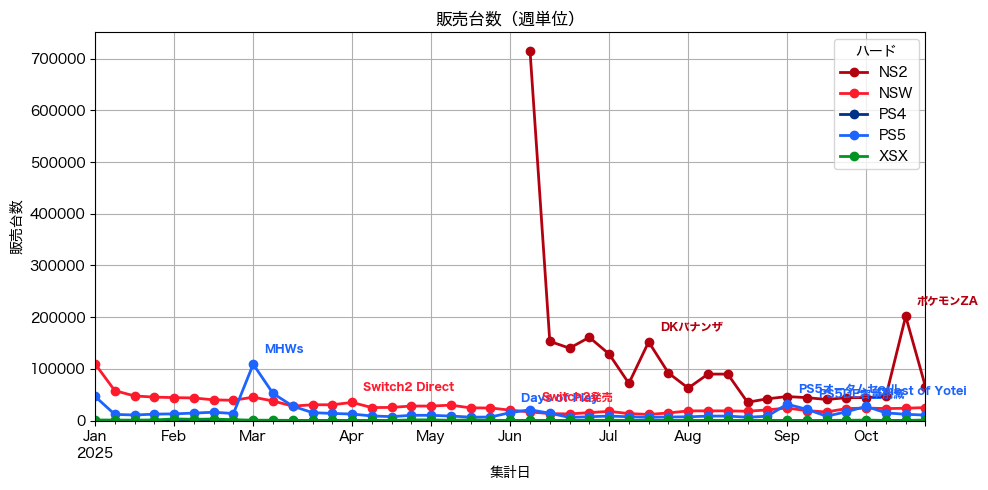

In [26]:
(fig, df) = ph.plot_sales(begin=datetime(2025,1,1), event_mask = report_event_mask)

### 2025年の週販推移(拡大）

急峻なZAの山が出来ました。
Switch2の出荷がメリハリありすぎて、今後どうなるのかはわかりません。

PS5はセール効果の無くなる次週は1万台を切ると思われます。


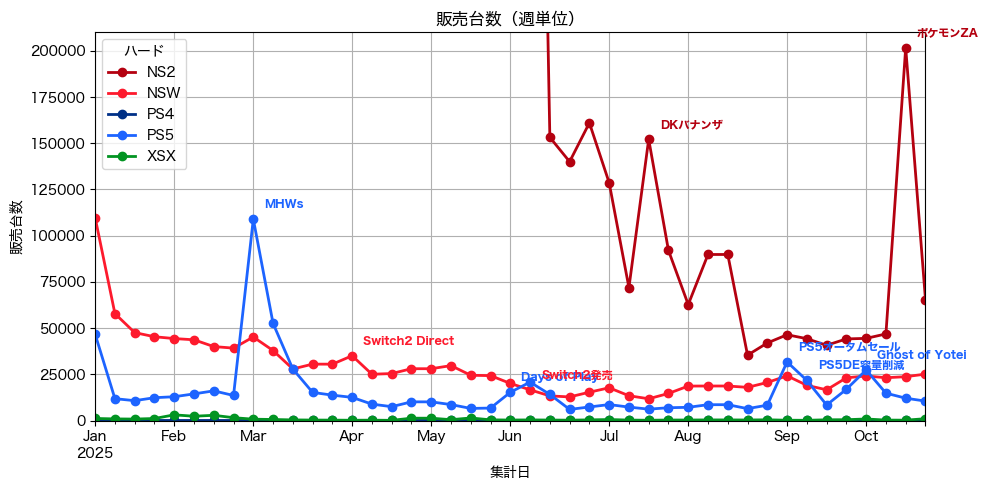

In [27]:
(fig, df) = ph.plot_sales(begin=datetime(2025,1,1), ymax=210000, event_mask=report_event_mask)

## 2025年月間販売推移

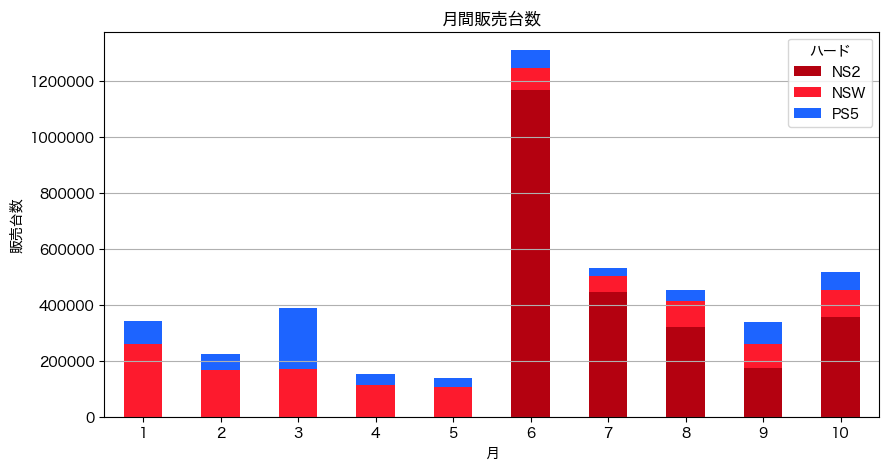

In [28]:
(fig, df) = ph.plot_monthly_bar_by_hard(hw=["NS2", "PS5", "NSW"], year=2025, stacked=True)

Switch2の10月販売台数が第2週の時点で9月の月間販売台数を超えました。

In [14]:
df = df.style.format({'NS2': '{:,.0f}', 'NSW': '{:,.0f}', 'PS5': '{:,.0f}'})
display(df)

hw,NS2,NSW,PS5
month,,,
1,0,"260,447","81,587"
2,0,"167,188","56,886"
3,0,"171,921","218,300"
4,0,"113,513","38,983"
5,0,"106,506","32,001"
6,"1,169,684","78,097","63,516"
7,"444,706","57,532","28,959"
8,"319,690","94,517","39,004"
9,"175,542","82,946","78,693"


### Nintendo Switchの月間販売台数： 2023,2024年との比較

Switch2大量出荷にも関わらずSwitchの販売台数は安定しています。
昨年比で減少は当然ですが、10月は9月よりはマシな前年比になりそうです。


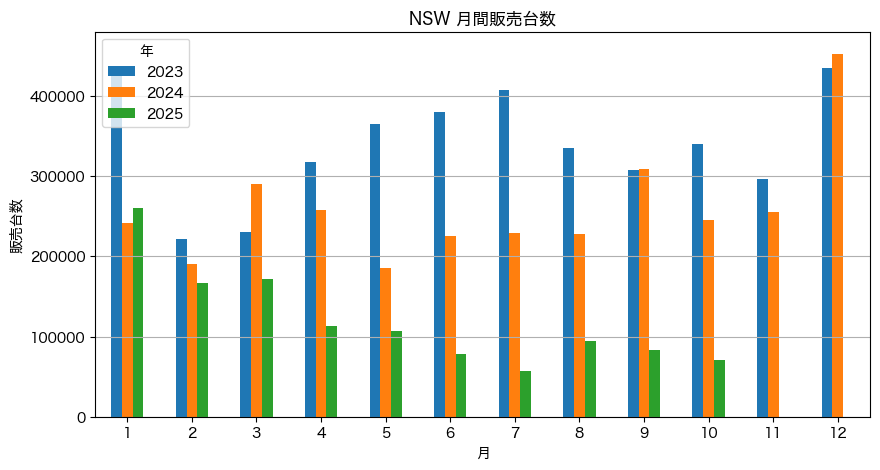

In [15]:
(fig, df) = ph.plot_monthly_bar_by_year(hw="NSW", ymax=480000, begin=datetime(2023,1,1), end=datetime(2025,10,19))

### PlayStation 5の月間販売台数： 2023, 2024年との比較

2025年10月のPS5は前年の10月を超えました。9月に続き2ヶ月連続で前年超えです。
しかし、昨年の11月、12月は高い値が出ているので、これを超えるには相当な規模での値下げセールが必要と思われます。


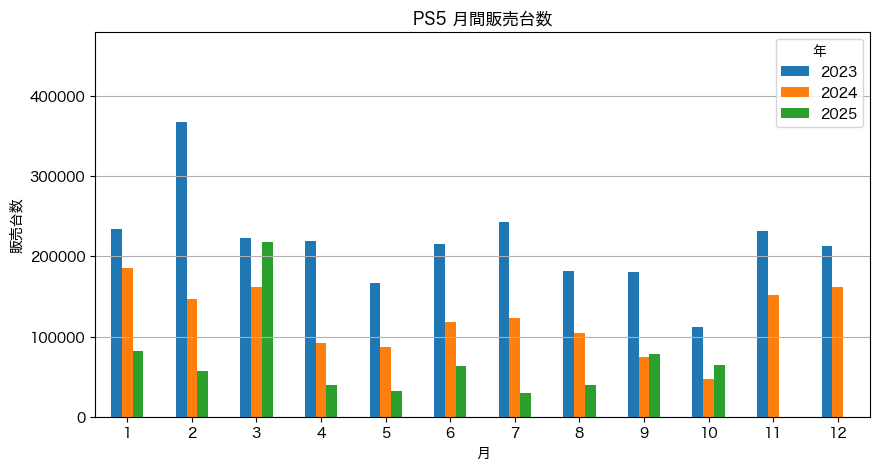

In [16]:
(fig, df) = ph.plot_monthly_bar_by_year(hw="PS5", ymax=480000, begin=datetime(2023,1,1), end=datetime(2025,10,26))

In [17]:
df

year,2023,2024,2025
month,,,
1,234329.0,185480.0,81587.0
2,366982.0,146945.0,56886.0
3,222656.0,162281.0,218300.0
4,219646.0,91981.0,38983.0
5,166660.0,87218.0,32001.0
6,215521.0,117592.0,63516.0
7,243383.0,123087.0,28959.0
8,181361.0,104178.0,39004.0
9,181056.0,74523.0,78693.0


## 累計販売推移

Switch2 20万台の大量出荷がありましたが、累計グラフの見た目の変化はまだ大きくありません（右端が気持ち上がったかな程度）。
今後のSwitch2 年末商戦で変化があるでしょう。

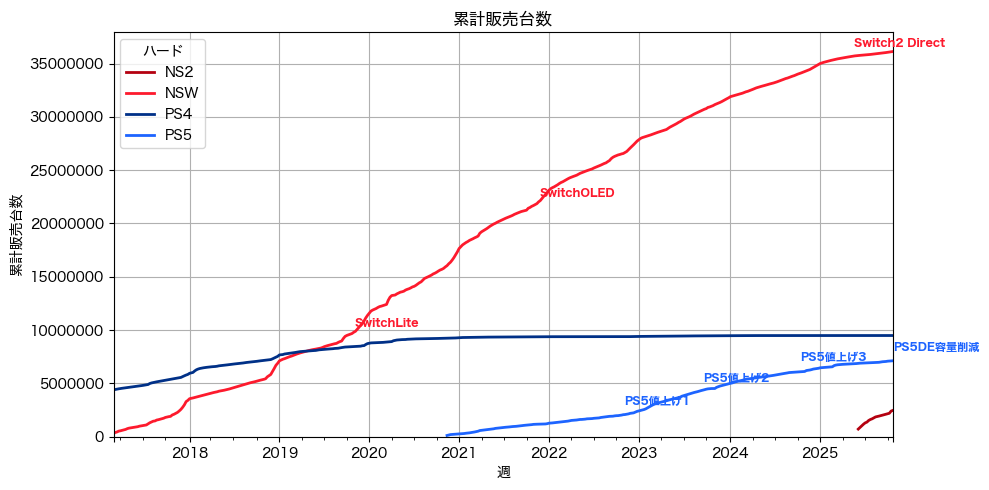

In [18]:
long_range_event_mask = he.EventMasks(hard=0.5, soft=0, event=0, price=0, sale=0)
(fig, df) = ph.plot_cumulative_sales(hw=['PS4', 'NS2', 'PS5', 'NSW'], begin=datetime(2017,3,1), event_mask = long_range_event_mask)


## Switch2販売状況

### 歴代機種との比較

ZA発売週の20万台がグラフの傾きにハッキリと現れています。
今後、初動歴代2位から3位に落ちる可能性はないでしょう。
歴代1位を狙えるかどうかが焦点になります。

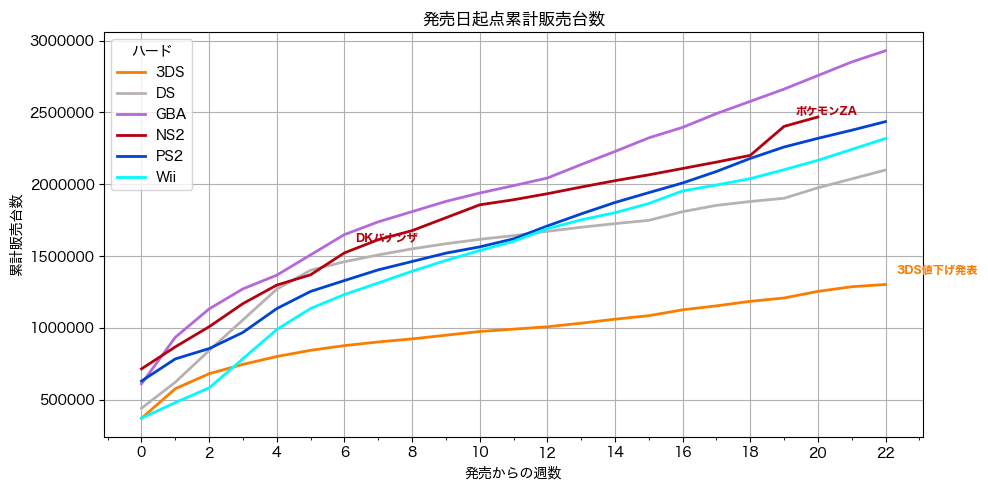

In [25]:
(fig, df) = ph.plot_cumulative_sales_by_delta(hw=["GBA", "NS2", "DS", "PS2", "Wii", "3DS"], 
                                        mode="week", xgrid=2, end=22,
                                        event_mask=report_event_mask)

In [24]:
df12 = df.iloc[df.index == 20]
# df12をunpivotして、列名を"ハード"、"販売数"にする
df12_unpivot = df12.unstack().reset_index()
df12_unpivot.columns = ['ハード', '週数', '販売数']
df12_unpivot.sort_values(by='販売数', ascending=False, inplace=True)
df12_unpivot.set_index('ハード', inplace=True)
display(df12_unpivot.style.format({'販売数': '{:,.0f}'}))

,週数,販売数
ハード,,
GBA,20,"2,756,318"
NS2,20,"2,468,021"
PS2,20,"2,319,488"
Wii,20,"2,166,405"
DS,20,"1,975,309"
3DS,20,"1,254,604"


### 累計300万到達の可能性と比較

今年の集計もあと9回。この先、年末まで平均7万/週で行けるなら、今年中に累計310万台に到達します。
過去機種で300万到達の時期を見てみると、最短はGAME BOY ADVANCEです。
Switch2はこれと1ヶ月差での300万台到達になると見込まれます。


In [20]:
hard_sales_df= hs.load_hard_sales()
df = hs.extract_week_reached_units(hard_sales_df, threshold_units=3000000)
df = df[['full_name', 'report_date', 'delta_week','sum_units']]
df = df.sort_values(by=['delta_week'])
df.columns = ['ハード', '達成年週', '週数', '累計販売数']
df.set_index(['ハード'], inplace=True)
display(df.head(10))

,達成年週,週数,累計販売数
ハード,,,
GAME BOY ADVANCE,2001-09-09,24,3051291
Wii,2007-07-15,32,3014828
Nintendo 3DS,2011-12-11,41,3233571
Nintendo DS,2005-09-18,41,3015412
PlayStation2,2000-12-17,41,3005742
Nintendo Switch,2017-12-24,42,3291903
PocketStation,2000-01-23,52,3011335
PlayStation Portable,2006-02-26,63,3021494
Nintendo GAMECUBE,2004-01-04,120,3115532


## Switch/Switch2ロンチ比較

#### Switch2 20万台の大量出荷

ロンチ週以降のSwitchとSwitch2の販売状況の比較です。

ついに到来したZA発売週。Switch2の週販第2位の20万台が目立ちます。
年末年始中は、以前のように5万台水準に戻ることはないと思いますが、10万台前後の出荷が継続することを期待したいですね。


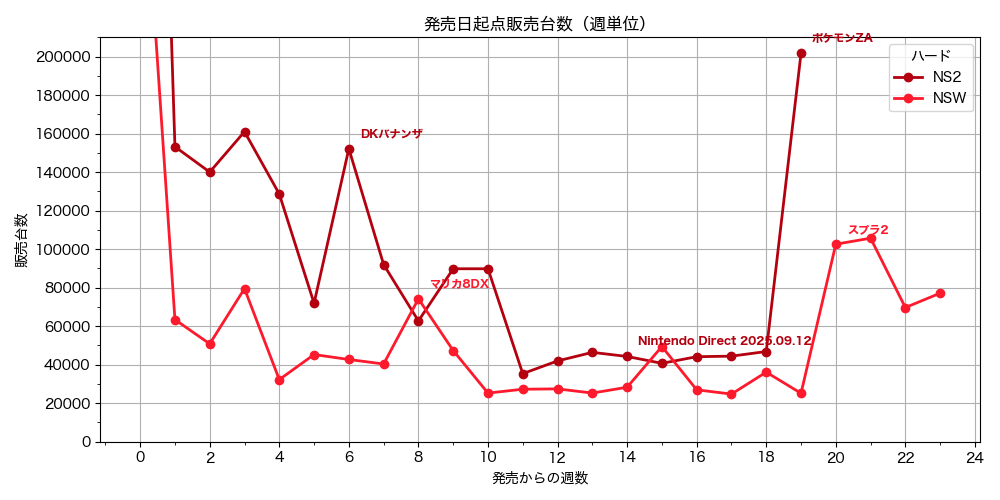

In [15]:
switch_event_mask = he.EventMasks(hard=5, event=2, soft=3, price=0, sale=0)
(fig, df) = ph.plot_sales_by_delta(hw=["NSW", "NS2"], 
                                   end=23, ymax=210000, xgrid=2, ygrid=20000, mode="week", 
                                   event_mask=switch_event_mask)


## 年単位の状況

全機種合わせた年毎のハード販売の状況です。
2025年は500万台を超える見込みですが、600万台到達は難しそうです。
（しかし、ブルームバーグ報道のようにSwitch2を年度内2000万台（ワールドワイドで）販売できるのならワンチャンあります）


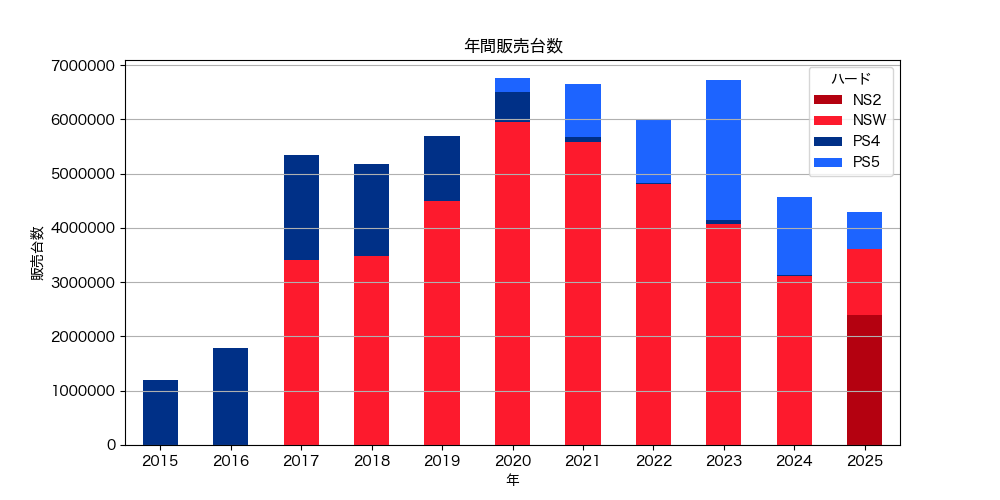

In [16]:
(fig, df) = ph.plot_yearly_bar_by_hard(hw=['PS4', 'PS5', 'NSW', 'NS2'], 
                                       begin=datetime(2015,1,1), 
                                       end=datetime(2025,12,31), stacked=True)

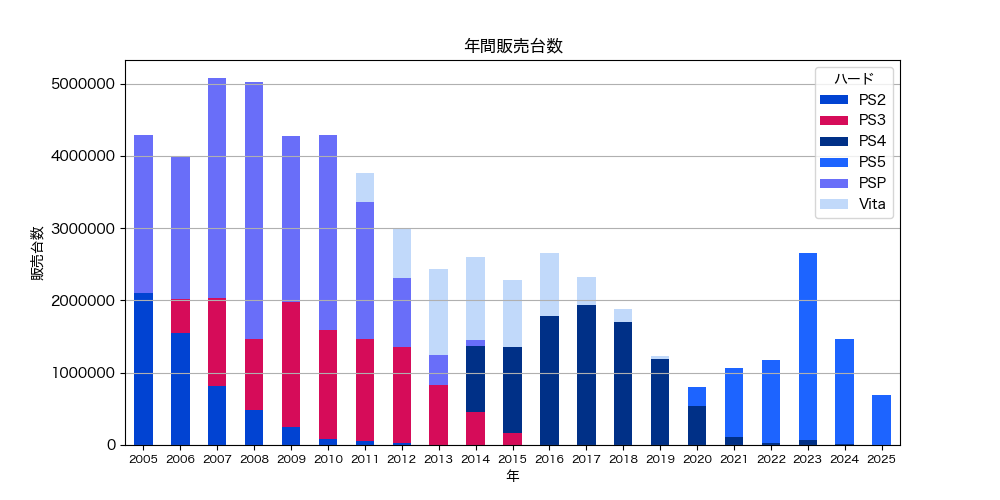

In [18]:
(fig, df) = ph.plot_yearly_bar_by_hard(hw=['PS5', 'PS4', 'PS3', 'PS2', "PS", "PSP", "Vita"], 
                                       begin=datetime(2005,1,1), end=datetime(2025,12,31), 
                                       stacked=True, 
                                       ticklabelsize=8)

                                       

In [19]:

df['sum'] = df.sum(axis=1)
df

hw,PS2,PS3,PS4,PS5,PSP,Vita,sum
year,,,,,,,
2005,2102274.0,0.0,0.0,0.0,2194008.0,0.0,4296282.0
2006,1554469.0,466716.0,0.0,0.0,1969363.0,0.0,3990548.0
2007,818773.0,1216483.0,0.0,0.0,3038311.0,0.0,5073567.0
2008,480806.0,991256.0,0.0,0.0,3552105.0,0.0,5024167.0
2009,253617.0,1723036.0,0.0,0.0,2305627.0,0.0,4282280.0
2010,89573.0,1500659.0,0.0,0.0,2704976.0,0.0,4295208.0
2011,56235.0,1414745.0,0.0,0.0,1889806.0,402794.0,3763580.0
2012,26201.0,1332548.0,0.0,0.0,951496.0,680895.0,2991140.0
2013,4689.0,818804.0,0.0,0.0,419889.0,1191450.0,2434832.0


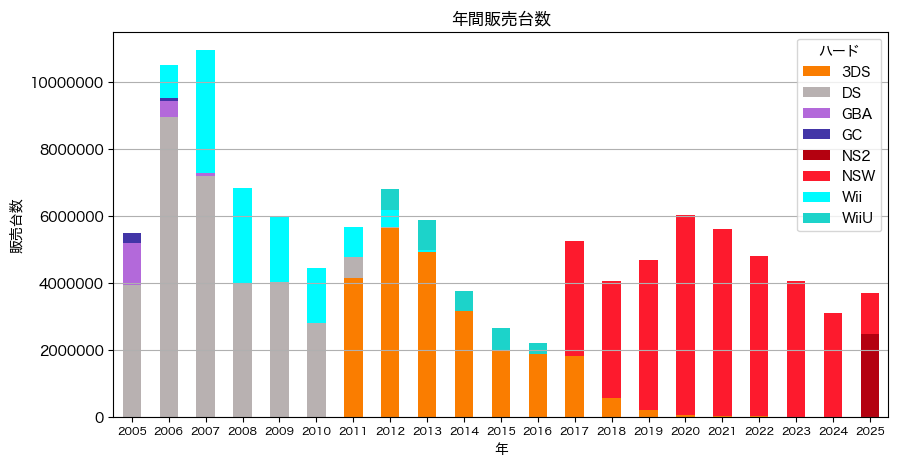

In [29]:
(fig, df) = ph.plot_yearly_bar_by_hard(hw=['N64', 'GC', 'Wii', 'WiiU', "NSW", "NS2", "GBA", "DS", "3DS"], 
                                       ymax=11500000, begin=datetime(2005,1,1), 
                                       end=datetime(2025,12,31), stacked=True,
                                       ticklabelsize=8)

In [24]:
df['sum'] = df.sum(axis=1)
df

hw,3DS,DS,GBA,GC,NS2,NSW,Wii,WiiU,sum
year,,,,,,,,,
2005,0.0,3939096.0,1251834.0,304895.0,0.0,0.0,0.0,0.0,5495825.0
2006,0.0,8966021.0,451045.0,100796.0,0.0,0.0,989118.0,0.0,10506980.0
2007,0.0,7202068.0,74290.0,5710.0,0.0,0.0,3670002.0,0.0,10952070.0
2008,0.0,3963304.0,9374.0,0.0,0.0,0.0,2857281.0,0.0,6829959.0
2009,0.0,4013845.0,0.0,0.0,0.0,0.0,1956578.0,0.0,5970423.0
2010,0.0,2785954.0,0.0,0.0,0.0,0.0,1651288.0,0.0,4437242.0
2011,4132038.0,648509.0,0.0,0.0,0.0,0.0,873406.0,0.0,5653953.0
2012,5646213.0,27662.0,0.0,0.0,0.0,0.0,491659.0,635290.0,6800824.0
2013,4912059.0,0.0,0.0,0.0,0.0,0.0,78677.0,883137.0,5873873.0
